In [1]:
import os
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans
from PIL import Image

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from sklearn.cluster import KMeans
import csv

# --- Utility Functions ---

def extract_fashion_house(image_name):
    """Extract and standardize fashion house name from image filename."""
    name = image_name.split('Look')[0]
    return "Schiaparelli" if "Schiaperelli" in name else name.strip()

def resize_image(image, factor=5):
    """Resize image to speed up processing."""
    return image.resize((image.width // factor, image.height // factor))

# --- Color Extraction ---

def extract_dominant_colors(image_path, n_colors=10):
    """Extract dominant colors using KMeans clustering."""
    image = Image.open(image_path).convert('RGB')
    image = resize_image(image)
    pixels = np.array(image).reshape(-1, 3)

    if len(np.unique(pixels, axis=0)) < n_colors:
        return np.unique(pixels, axis=0)  # fallback if too few colors

    kmeans = KMeans(n_clusters=n_colors, n_init='auto')
    kmeans.fit(pixels)

    sorted_centroids = sorted(zip(np.bincount(kmeans.labels_), kmeans.cluster_centers_),
                              key=lambda x: x[0], reverse=True)
    return np.array([centroid for _, centroid in sorted_centroids])

def extract_unique_colors(image_path):
    """Extract unique RGB colors from the image."""
    image = Image.open(image_path).convert('RGB')
    image = resize_image(image)
    pixels = np.array(image).reshape(-1, 3)
    return np.unique(pixels, axis=0)

# --- Load Color Palettes ---

def load_clustered_palettes(folder_path, n_colors=10):
    """Load clustered palettes for each fashion house."""
    palettes = defaultdict(list)
    for file in os.listdir(folder_path):
        if file.lower().endswith('.png'):
            path = os.path.join(folder_path, file)
            house = extract_fashion_house(file)
            dominant_colors = extract_dominant_colors(path, n_colors)
            palettes[house].append(dominant_colors)
    return palettes

# --- Mocha Mousse Color Analysis ---

def find_closest_to_mocha(palettes, target_rgb=np.array([150, 111, 94])):
    """Find the fashion house whose colors are closest to Mocha Mousse."""
    house_distances = {}

    for house, palette_list in palettes.items():
        all_colors = np.vstack(palette_list)
        dists = np.linalg.norm(all_colors - target_rgb, axis=1)
        min_dist = np.min(dists)
        house_distances[house] = min_dist

    closest_house = min(house_distances, key=house_distances.get)
    return closest_house, house_distances[closest_house], house_distances

# --- Plot Mocha Mousse Comparison with Updated House Order ---

def plot_mocha_comparison(palettes, target_rgb=np.array([150, 111, 94]), top_n=3, save_path=None):
    """Plot the closest colors to Mocha Mousse and save as image."""
    closest = []

    for house, palette_list in palettes.items():
        all_colors = np.vstack(palette_list)
        dists = np.linalg.norm(all_colors - target_rgb, axis=1)
        idx = np.argmin(dists)
        closest.append((house, dists[idx], all_colors[idx]))

    closest.sort(key=lambda x: x[1])
    top = closest[:top_n]

    # Set up plot with enhanced aesthetics
    fig, ax = plt.subplots(figsize=(10, 4))

    # Adjust the order of houses to be: Chanel -> Schiaparelli -> Jacquemus
    house_order = ['Chanel', 'Schiaparelli', 'Jacquemus']
    house_distances = {house: dist for house, dist, _ in closest}

    # Normalize distances to get bar heights
    max_distance = max(house_distances.values())
    
    # Plot fashion houses in desired order: Chanel -> Schiaparelli -> Jacquemus
    for i, house in enumerate(house_order):
        dist = house_distances[house]
        color = next(color for h, _, color in closest if h == house)
        
        # Resize Jacquemus to have a smaller bar and others larger accordingly
        bar_height = dist / max_distance  # Normalize bar height based on distance
        
        ax.add_patch(plt.Rectangle((i * 2, 0), 1.5, bar_height, color=color / 255))  # Use normalized bar height
        ax.text(i * 2 + 0.75, bar_height + 0.05, f'{dist:.2f}', ha='center', va='bottom', fontsize=10, weight='bold', color='black')
        ax.text(i * 2 + 0.75, -0.1, house, ha='center', va='top', fontsize=10, rotation=45, weight='bold', color='black')

    # Add Mocha Mousse color swatch and text
    ax.add_patch(plt.Rectangle((top_n * 2, 0), 1, 1, color=target_rgb / 255))
    ax.text(top_n * 2 + 0.5, -0.1, 'Mocha Mousse', ha='center', va='top', fontsize=12, weight='bold', color='brown')

    # Style the plot with improved visuals
    ax.set_xlim(0, top_n * 2 + 2)
    ax.set_ylim(0, 1)
    ax.axis('off')
    fig.suptitle("Fashion Houses Closest to Mocha Mousse", fontsize=16, weight='bold', color='brown')

    # Customize background color and layout for aesthetics
    fig.patch.set_facecolor('whitesmoke')
    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        fig.savefig(save_path, dpi=300)
        print(f"📸 Plot saved to: {save_path}")

    plt.show()

# --- Save Data to CSV ---

def save_to_csv(house_distances, file_path):
    """Save fashion house distances to a CSV file."""
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Fashion House", "Distance to Mocha Mousse"])
        for house, dist in house_distances.items():
            writer.writerow([house, dist])

The fashion house closest to Mocha Mousse is: Jacquemus (Distance: 3.79)

Top fashion houses to Mocha Mousse:
1. Jacquemus: Distance 3.79
2. Schiaparelli: Distance 9.20
3. Chanel: Distance 12.91
📸 Plot saved to: /Users/user/Desktop/Color Trends/mocha_mousse_comparison.png


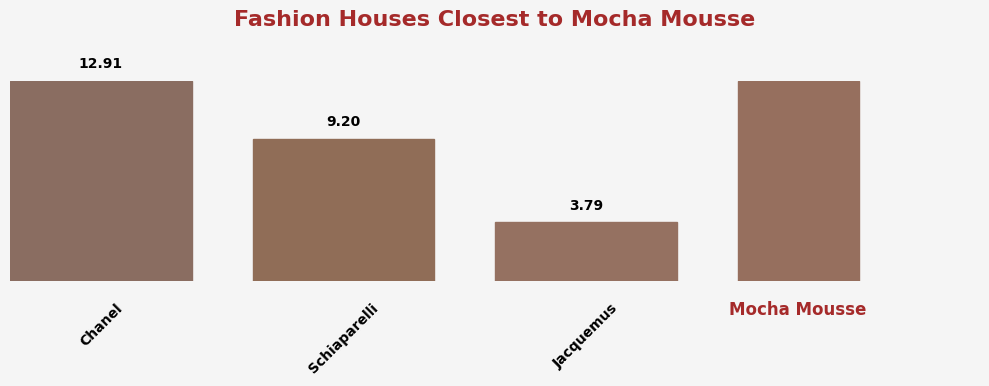

In [4]:

# --- Main Execution ---

if __name__ == "__main__":
    palette_folder = "/Users/user/Desktop/Project Submission/Implementation/Source Code/Source Code/project 2/public/images/ColorAnalysisResults" 
    save_dir = "/Users/user/Desktop/Color Trends"  # Directory to save plot and CSV

    # Load color palettes (clustered)
    clustered_palettes = load_clustered_palettes(palette_folder)

    # Find closest fashion house to Mocha Mousse
    closest_house, dist, all_dists = find_closest_to_mocha(clustered_palettes)
    print(f"The fashion house closest to Mocha Mousse is: {closest_house} (Distance: {dist:.2f})")

    # Sort all fashion houses by distance to Mocha Mousse
    sorted_houses = sorted(all_dists.items(), key=lambda x: x[1])
    print("\nTop fashion houses to Mocha Mousse:")

    # Chanel is at the top, followed by other houses
    top_houses = sorted_houses[:3]  # Top 3 closest houses
    for i, (house, distance) in enumerate(top_houses):
        print(f"{i+1}. {house}: Distance {distance:.2f}")

    # Save CSV with house distances
    csv_file = os.path.join(save_dir, "fashion_houses_to_mocha_mousse.csv")
    save_to_csv(all_dists, csv_file)

    # Plot the comparison and save to desktop
    plot_image_path = os.path.join(save_dir, "mocha_mousse_comparison.png")
    plot_mocha_comparison(clustered_palettes, target_rgb=np.array([150, 111, 94]), top_n=3, save_path=plot_image_path)